numpy=1.21
mediapipe=0.8.8.1
tensorflow=2.6.0
opencv-python=4.5.3.56
pyspellchecker=0.6.2
sklearn=1.0
matplotlib=3.4.3

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from math import ceil
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [2]:
from spellchecker import SpellChecker


def Auto_Correct(word):
    mySpellChecker = SpellChecker()
    return mySpellChecker.correction(word)

In [6]:
# cnn.py

class Model:

  classifier = None
  def __init__(self, Type):
    self.classifier = Type
    
  def build_model(classifier):
    

    classifier.add(Convolution2D(128, (3, 3), input_shape=(64, 64, 1), activation='relu'))

    classifier.add(Convolution2D(256, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    classifier.add(Convolution2D(256, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    
    classifier.add(Convolution2D(512, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.5))

    classifier.add(Convolution2D(512, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.5))

    classifier.add(Flatten())

    classifier.add(Dropout(0.5))
    
    classifier.add(Dense(1024, activation='relu'))
    

    classifier.add(Dense(29, activation='softmax'))

    return classifier

  def save_classifier(path, classifier):
    classifier.save(path)

  def load_classifier(path):
    classifier = load_model(path)
    return classifier

  def predict(classes, classifier, img):
    img = cv2.resize(img, (64, 64))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255.0

    pred = classifier.predict(img)
    return classes[np.argmax(pred)], pred
    

class DataGatherer:

  def __init__(self, *args):
    if len(args) > 0:
      self.dir = args[0]
    elif len(args) == 0:
      self.dir = ""

  #this function loads the images along with their labels and apply pre-processing function on the images 
  # and finaly split them into train and test dataset
  def load_images(self):
    images = []
    labels = []
    index = -1
    folders = sorted(os.listdir(self.dir))
    
    for folder in folders:
      index += 1
      
      print("Loading images from folder ", folder ," has started.")
      for image in os.listdir(self.dir + '/' + folder):

        img = cv2.imread(self.dir + '/' + folder + '/' + image, 0)
        
        img = self.edge_detection(img)
        img = cv2.resize(img, (64, 64))
        img = img_to_array(img)

        images.append(img)
        labels.append(index)

    images = np.array(images)
    images = images.astype('float32')/255.0
    labels = to_categorical(labels)

    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1)

    return x_train, x_test, y_train, y_test

  def edge_detection(self, image):
    minValue = 70
    blur = cv2.GaussianBlur(image,(5,5),2)
    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return res

Loading images from folder  A  has started.
Loading images from folder  B  has started.
Loading images from folder  C  has started.
Loading images from folder  D  has started.
Loading images from folder  E  has started.
Loading images from folder  F  has started.
Loading images from folder  G  has started.
Loading images from folder  H  has started.
Loading images from folder  I  has started.
Loading images from folder  J  has started.
Loading images from folder  K  has started.
Loading images from folder  L  has started.
Loading images from folder  M  has started.
Loading images from folder  N  has started.
Loading images from folder  O  has started.
Loading images from folder  P  has started.
Loading images from folder  Q  has started.
Loading images from folder  R  has started.
Loading images from folder  S  has started.
Loading images from folder  T  has started.
Loading images from folder  U  has started.
Loading images from folder  V  has started.
Loading images from folder  W  h

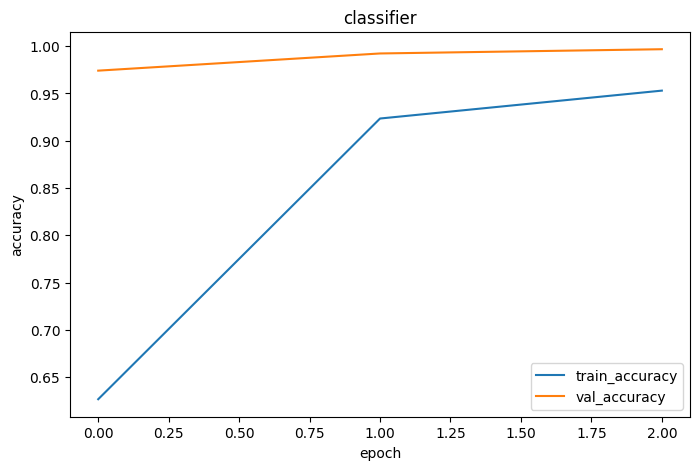

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model.

In [7]:
# train.py

training_dir = 'Dataset\\asl_alphabet_train'

#loading the images from training directory
data_gatherer = DataGatherer(training_dir)

x_train, x_test, y_train, y_test = data_gatherer.load_images()

batch_size = 64
training_size = x_train.shape[0]
test_size = x_test.shape[0]


#computing steps and validation steps per epoch according to training and testing size
compute_steps_per_epoch = lambda x: int(ceil(1. * x/batch_size))
steps_per_epoch = compute_steps_per_epoch(training_size)
val_steps = compute_steps_per_epoch(test_size)

#build the model
classifier = Model(Sequential()).classifier
classifier = Model.build_model(classifier)

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = classifier.fit(
  x_train, y_train,
  steps_per_epoch=steps_per_epoch,
  epochs=3,
  validation_data=(x_test, y_test),
  validation_steps=val_steps)

#plot accuracy graph
plt.figure(figsize=(8,5))

plt.plot(history.history['accuracy'], label='train_accuracy',)
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title("classifier")

plt.show();

# Save the model using the save_classifier method
path = "saved_model"  # Specify the file path
Model.save_classifier(path, classifier)
print(f"Model saved to {path}")

In [9]:
# Save the model using the save_classifier method
path = "saved_model.h5"  # Specify the file path
Model.save_classifier(path, classifier)
print(f"Model saved to {path}")

Model saved to saved_model.h5


In [10]:
# Save the model using the save_classifier method in .keras format
path = "model.keras"  # Specify the file path
Model.save_classifier(path, classifier)
print(f"Model saved to {path}")

Model saved to model.keras
